In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score, roc_curve, auc, silhouette_score
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

## 0. Изучение данных

In [41]:
df = pd.read_excel('Тест кандидата на вакансию в Отдел скоринговых систем.xls')

In [42]:
df.columns = ['id', 'age', 'age_years', 'gender', 'removal', 'foreign_passport',
 'married', 'children', 'dependents', 'education',
 'foreign_language', 'car_ownership', 'industry', 'job_direction',
 'employer', 'position', 'family_income', 'income_per_capita',
 'personal_income', 'loan_amount_issued', 'branch', 'city',
 'requested_amount', 'actual_owner', 'spouse_income', 'credits_paid_off',
 'first_loan', 'default_60']

df.columns

Index(['id', 'age', 'age_years', 'gender', 'removal', 'foreign_passport',
       'married', 'children', 'dependents', 'education', 'foreign_language',
       'car_ownership', 'industry', 'job_direction', 'employer', 'position',
       'family_income', 'income_per_capita', 'personal_income',
       'loan_amount_issued', 'branch', 'city', 'requested_amount',
       'actual_owner', 'spouse_income', 'credits_paid_off', 'first_loan',
       'default_60'],
      dtype='object')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6010 entries, 0 to 6009
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  6010 non-null   int64  
 1   age                 6010 non-null   float64
 2   age_years           6010 non-null   int64  
 3   gender              6010 non-null   int64  
 4   removal             6010 non-null   int64  
 5   foreign_passport    6010 non-null   int64  
 6   married             6010 non-null   int64  
 7   children            6010 non-null   int64  
 8   dependents          6010 non-null   int64  
 9   education           6010 non-null   int64  
 10  foreign_language    6010 non-null   int64  
 11  car_ownership       6010 non-null   int64  
 12  industry            6010 non-null   int64  
 13  job_direction       6010 non-null   int64  
 14  employer            6010 non-null   int64  
 15  position            6010 non-null   int64  
 16  family

In [44]:
df.head()

,id,age,age_years,gender,removal,foreign_passport,married,children,dependents,education,...,personal_income,loan_amount_issued,branch,city,requested_amount,actual_owner,spouse_income,credits_paid_off,first_loan,default_60
0,1,26.936986,27,1,0,0,2,0,0,2,...,20000,60000.0,27,10,60000,5,0,0,0,0
1,3,31.742466,32,2,0,0,1,2,2,2,...,10000,50000.0,29,12,50000,4,12000,0,1,0
2,4,23.172603,23,1,0,0,1,1,1,2,...,15000,30000.0,39,1,30000,3,0,1,0,1
3,5,24.424658,24,1,0,0,2,0,0,2,...,20000,70000.0,115,1,70000,3,0,0,0,1
4,6,28.654795,29,2,0,0,2,0,0,2,...,10000,15000.0,53,9,15000,1,0,0,0,0


In [45]:
df.duplicated().sum()

0

In [46]:
df['personal_income'].describe()

count     6010.00000
mean     13632.76223
std       5599.93635
min       3000.00000
25%      10000.00000
50%      12800.00000
75%      17000.00000
max      30000.00000
Name: personal_income, dtype: float64

## 1. Кластеризация клиентов

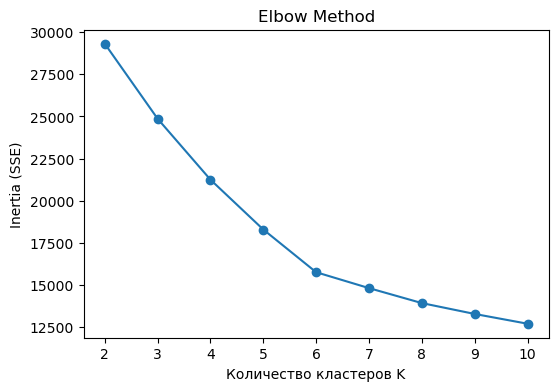

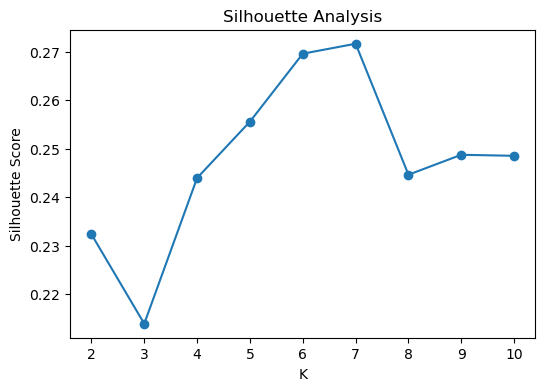

In [47]:
test_df = df.copy()
features = ['age', 'personal_income', 'position', 'married', 'family_income', 'education']
X = test_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, '-o')
plt.xlabel('Количество кластеров K')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method')
plt.show()

sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6, 4))
plt.plot(K_range, sil_scores, '-o')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [48]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
test_df['cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = test_df.groupby('cluster')[features].median().round(2)
print(cluster_summary)

           age  personal_income  position  married  family_income  education
cluster                                                                     
0        27.68          15000.0       5.0      2.0        20000.0        3.0
1        45.41          11500.0       5.0      3.0        13000.0        2.0
2        25.92          11000.0       5.0      2.0        17000.0        2.0
3        38.01          20000.0       3.0      1.0        27000.0        3.0
4        34.00          20000.0       5.0      1.0        35000.0        2.0
5        46.75          10000.0       5.0      1.0        21000.0        2.0


Оптимальное количество сегментов исходя из графиков - 6, однако сложно описать конкретный портрет каждого из видов клиента, так как на руках не имеется расшифровки что означает каждый конкретный параметр.

## 2. Обучение моделей для скринингового анализа и их оценка

In [49]:
corr_koef = df.corr(numeric_only=True)

field_drop = [col for col in corr_koef.columns if corr_koef[col].isnull().all()]

corr_field = []
for i in corr_koef.columns:
    for j in corr_koef.index[corr_koef[i] > 0.9]:
        if i != j and j not in corr_field and i not in corr_field:
            corr_field.append(j)
            print(f"{i} --> {j}: r = {corr_koef.loc[j, i]:.2f}")

print(f"Удаляем признаки: {field_drop + corr_field}")

df = df.drop(columns=field_drop + corr_field)

age --> age_years: r = 1.00
loan_amount_issued --> requested_amount: r = 0.97
Удаляем признаки: ['age_years', 'requested_amount']


Удалил пустые (только с одним вариантом значения) и сильно скоррелированные признаки.

In [50]:
X = df.drop('default_60', axis=1)
y = df['default_60']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Отделил признаки и целевую переменную, поделил выборку на тестовую и обучающую, а также стандартизировал признаки.

In [51]:
sm = SMOTE(random_state=0)
X_train_bal, y_train_bal = sm.fit_resample(X_train_st, y_train)

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=4,
    verbose=0,
    random_state=0
)

cat_model.fit(X_train_bal, y_train_bal)

Использовал SMOTE, чтобы устранить дисбаланс классов в выборках (0 значительно больше, чем 1).  
Обучил CatBoost, использовал гиперпараметры, которые нашел ранее с помощью тюнинга.

In [52]:
y_prob = cat_model.predict_proba(X_test_st)[:, 1]

thresholds = np.linspace(0.1, 0.9, 17)
f1_scores = []
recalls = []

print("Порог | F1-score | Recall")
for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    recalls.append(rec)
    print(f"{t:.2f}  |   {f1:.3f}   |  {rec:.3f}")

auc_score = roc_auc_score(y_test, y_prob)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nROC AUC: {auc_score:.3f}")
print(f"Лучший порог по F1: {best_threshold:.2f}\n")

print(classification_report(y_test, (y_prob >= best_threshold).astype(int)))

Порог | F1-score | Recall
0.10  |   0.346   |  0.995
0.15  |   0.363   |  0.967
0.20  |   0.381   |  0.901
0.25  |   0.398   |  0.791
0.30  |   0.389   |  0.621
0.35  |   0.360   |  0.448
0.40  |   0.266   |  0.242
0.45  |   0.193   |  0.132
0.50  |   0.092   |  0.052
0.55  |   0.042   |  0.022
0.60  |   0.016   |  0.008
0.65  |   0.000   |  0.000
0.70  |   0.000   |  0.000
0.75  |   0.000   |  0.000
0.80  |   0.000   |  0.000
0.85  |   0.000   |  0.000
0.90  |   0.000   |  0.000

ROC AUC: 0.656
Лучший порог по F1: 0.25

              precision    recall  f1-score   support

           0       0.89      0.45      0.60      1439
           1       0.27      0.79      0.40       364

    accuracy                           0.52      1803
   macro avg       0.58      0.62      0.50      1803
weighted avg       0.77      0.52      0.56      1803



Модель определенно нельзя назвать идеальной, подбирал порог для увеличения F1 и относительно небольшого уменьшения Recall.

In [53]:
param_dists = {
    'XGBClassifier': {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8]
    },
    'CatBoostClassifier': {
        'iterations': [200, 500],
        'learning_rate': [0.01, 0.05],
        'depth': [4, 6]
    },
    'GradientBoostingClassifier': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05],
        'max_depth': [3, 5]
    }
}

models = [
    XGBClassifier(eval_metric='auc', random_state=0),
    CatBoostClassifier(verbose=0, random_state=0),
    GradientBoostingClassifier(random_state=0)
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
best_models = []

for model in models:
    name = model.__class__.__name__
    if name in param_dists:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dists[name],
            n_iter=min(20, sum([len(v) for v in param_dists[name].values()])),
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1,
            verbose=1,
            random_state=0
        )
        search.fit(X_train_st, y_train)
        print(f"{name}: лучший AUC = {search.best_score_:.3f}")
        best_models.append((name, search.best_estimator_))
    else:
        model.fit(X_train_st, y_train)
        best_models.append((name, model))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
XGBClassifier: лучший AUC = 0.656
Fitting 5 folds for each of 6 candidates, totalling 30 fits
CatBoostClassifier: лучший AUC = 0.658
Fitting 5 folds for each of 6 candidates, totalling 30 fits
GradientBoostingClassifier: лучший AUC = 0.650


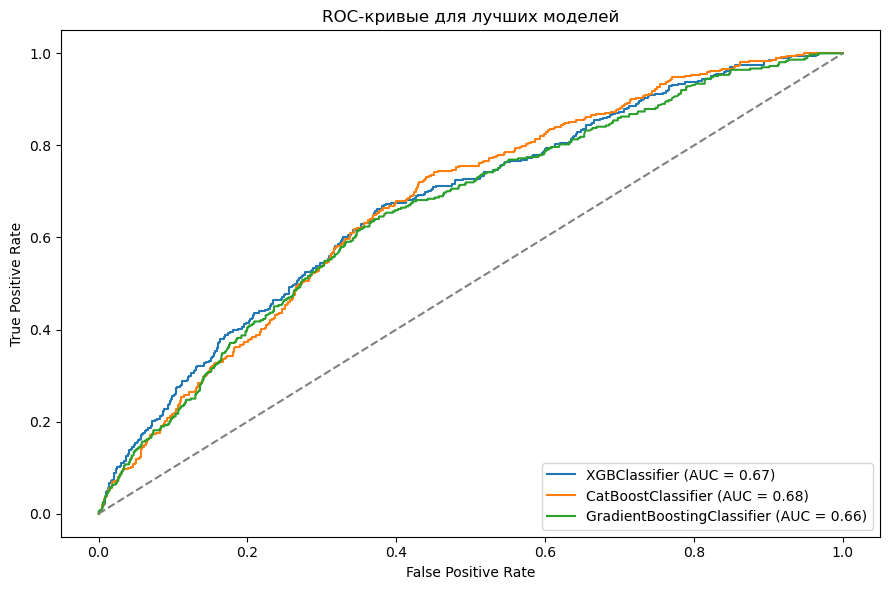

In [54]:
plt.figure(figsize=(9, 6))
for name, mdl in best_models:
    y_prob_model = mdl.predict_proba(X_test_st)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob_model)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для лучших моделей')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Затюнил гиперпараметры для нескольких моделей, сравнил их AUC (по нему и выбрал выше CatBoost), вывел ROC-кривые для всех трех моделей. До этого пробовал 7 моделей, однако все остальные показывали значения хуже, а времени на обучение и тюнинг гипепараметров уходило много, поэтому оставил 3 фаворитов для наглядности.

## 3. Прогноз значений для тестовой выборки

Загрузил тестовые данные, предсказал факт выхода в просрочку на срок более 60 дней, шанс этого выхода и перевел его в скоринговый балл, который принимает значение от 300 до 850.

In [55]:
df_test = pd.read_excel('Тест кандидата на вакансию в Отдел скоринговых систем.xls', sheet_name=1)
df_test.columns = [
    'id', 'age', 'age_years', 'gender', 'removal', 'foreign_passport',
    'married', 'children', 'dependents', 'education',
    'foreign_language', 'car_ownership', 'industry', 'job_direction',
    'employer', 'position', 'family_income', 'income_per_capita',
    'personal_income', 'loan_amount_issued', 'branch', 'city',
    'requested_amount', 'actual_owner', 'spouse_income', 'credits_paid_off',
    'first_loan', 'default_60', 'default_score'
]

df_test = df_test.drop(columns=['default_60', 'default_score'] + field_drop + corr_field)

X_test_new = scaler.transform(df_test)

y_prob_final = cat_model.predict_proba(X_test_new)[:, 1]
y_pred_final = (y_prob_final >= best_threshold).astype(int)

min_score = 300
max_score = 850

df_test['default_60_pred'] = y_pred_final
df_test['default_60_prob'] = y_prob_final
df_test['score'] = max_score - (y_prob_final * (max_score - min_score))

df_test.head()

,id,age,gender,removal,foreign_passport,married,children,dependents,education,foreign_language,...,loan_amount_issued,branch,city,actual_owner,spouse_income,credits_paid_off,first_loan,default_60_pred,default_60_prob,score
0,6047,34.942466,2,0,0,2,2,2,2,2,...,20000,73,10,5,20000,0,0,0,0.149541,767.752552
1,6048,34.476712,2,0,0,1,2,2,2,4,...,15000,79,12,2,8000,0,1,0,0.236068,720.162765
2,6049,35.843836,2,0,0,4,2,2,2,3,...,30000,153,10,1,0,1,0,0,0.202245,738.765346
3,6050,26.383562,2,0,0,1,1,1,3,4,...,20000,115,1,5,18000,0,1,0,0.128430,779.363398
4,6051,43.950685,2,0,0,3,3,3,2,4,...,13000,227,27,5,0,0,1,0,0.204955,737.274594
